In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
import os

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense

Using TensorFlow backend.


In [2]:
dataset_dir = os.path.abspath(r"./SMILEs/") #smile数据集路径
model_dir = os.path.abspath(r"./model/lenet.hdf5")    #训练模型保存路径

data = []
labels = []

In [3]:
for imagePath in sorted(list(paths.list_images(dataset_dir))):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   # 转换成灰度图像
    image = imutils.resize(image, width = 28)  #将图像尺寸改成28*28
    image = img_to_array(image)   #使用Keras的img_to_array转换成浮点型和（28*28*1），便于接下来神经网络学习
    data.append(image)
    
    label = imagePath.split(os.path.sep)[-3]
    label = "smiling" if label == "positives" else "not_smiling"  #如果label字符串里面有positive就重命名为smiling
    labels.append(label)

In [4]:
# 将data和labels都转换为numpy类型
data = np.array(data, dtype= "float") / 255.0 #将像素转换到[0, 1]范围之内
labels = np.array(labels)

# 对label进行one-hot编码
le = LabelEncoder().fit(labels)   # LabelEncoder可以将标签分配一个0—n_classes-1之间的编码 

# transform用来标准化，将labels中'not_smiling'和‘smiling’的数据转换成0和1的形式
labels = np_utils.to_categorical(le.transform(labels), 2)  # 2是num_class表示输出的是2列数据的意思

下面需要解决一下样本不平衡问题。

数据集里面有9475个笑脸样本，和3690个非笑脸样本。下面的代码中classTotals就是按列加和labels的one-hot编码，所以结果是[9475, 3690]
我们要解决数据不平衡问题可以使用classWeight权重，相比于笑脸，我们给非笑脸以2.56倍的权重。损失函数权重计算的时候对非笑脸进行相应扩大，以此来解决数据不平衡问题。

In [11]:
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

stratify是为了保持split前类的分布。比如有100个数据，80个属于A类，20个属于B类。如果train_test_split(... test_size=0.25, stratify = y_all), 那么split之后数据如下：

training: 75个数据，其中60个属于A类，15个属于B类。

testing: 25个数据，其中20个属于A类，5个属于B类。 

用了stratify参数，training集和testing集的类的比例是 A：B= 4：1，等同于split前的比例（80：20）。通常在这种类分布不平衡的情况下会用到stratify

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.20, 
                                                 stratify = labels, random_state = 42)

下面是模型部分,LeNet实现

In [13]:
model = Sequential()

# first set of CONV => RELU => POOL layers
model.add(Conv2D(input_shape=(28, 28, 1), kernel_size=(5, 5), filters=20, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(kernel_size=(5, 5), filters=50,  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500, activation='relu'))

model.add(Dense(2, activation='softmax'))

In [14]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

H = model.fit(trainX, trainY, validation_data = (testX, testY),
             class_weight = classWeight, batch_size = 64, epochs = 15, verbose = 1)  #verbose = 1显示进度条

Train on 10532 samples, validate on 2633 samples
Epoch 1/15
10532/10532 [==============================] - 5s 466us/step - loss: 0.3734 - acc: 0.8338 - val_loss: 0.2813 - val_acc: 0.8842
Epoch 2/15
10532/10532 [==============================] - 1s 85us/step - loss: 0.2662 - acc: 0.8937 - val_loss: 0.2624 - val_acc: 0.8959
Epoch 3/15
10532/10532 [==============================] - 1s 89us/step - loss: 0.2411 - acc: 0.9060 - val_loss: 0.2617 - val_acc: 0.8997
Epoch 4/15
10532/10532 [==============================] - 1s 88us/step - loss: 0.2248 - acc: 0.9152 - val_loss: 0.2522 - val_acc: 0.9020
Epoch 5/15
10532/10532 [==============================] - 1s 94us/step - loss: 0.2106 - acc: 0.9196 - val_loss: 0.2741 - val_acc: 0.8899
Epoch 6/15
10532/10532 [==============================] - 1s 97us/step - loss: 0.2008 - acc: 0.9239 - val_loss: 0.2388 - val_acc: 0.9051
Epoch 7/15
10532/10532 [==============================] - 1s 93us/step - loss: 0.1854 - acc: 0.9282 - val_loss: 0.2368 - val_acc

keras没有直接可以统计recall和f1值的办法。可以用sklearn。
但是sklearn没有办法直接处理Keras的数据，所以要经过一些处理。Keras计算需要二维数组，但classification_report可以处理的是一维数列，所以这里使用argmax按行返回二维数组最大索引，这样也算是一种0-1标签的划分了。

In [17]:
predictions = model.predict(testX, batch_size = 64)


print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1),
                           target_names = le.classes_))  # le.classes是['not_smiling', 'smiling']组成的数组

model.save(model_dir)

             precision    recall  f1-score   support

not_smiling       0.95      0.91      0.93      1895
    smiling       0.79      0.87      0.83       738

avg / total       0.90      0.90      0.90      2633



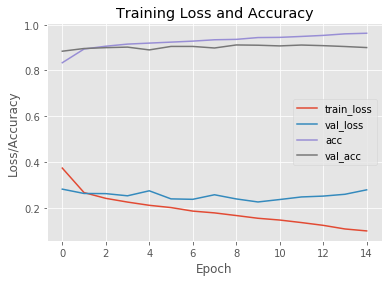

In [18]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 15), H.history["acc"], label = "acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")le
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### 进行实时显示

In [10]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import imutils
import cv2
import os

In [14]:
haarcascade_face_dir = os.path.abspath(r"./model/haarcascade_frontalface_default.xml")
model_dir = os.path.abspath(r"./model/lenet.hdf5")
video_dir = os.path.abspath(r"./src.mp4")

In [15]:
detector = cv2.CascadeClassifier(haarcascade_face_dir)
model = load_model(model_dir)
camera = cv2.VideoCapture(video_dir)

In [16]:
while True:
    (grabbed, frame) = camera.read()

    
# grabbed和frame是read的两个返回值，grabbed是布尔类型的返回值，如果读取帧是正确的返回True，当文件读到结尾的时候返回False
# frame是每一帧的图像，是一个三维矩阵   

    frame = imutils.resize(frame, width = 300) #把图像宽度重新指定为300像素
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #因为模型训练是对灰度图像处理，所以这里要转换成灰度图像
    frameClone = frame.copy()    #重新克隆frame，用于接下来绘制边界框

     # scaleFactor用来控制图像金字塔， minNeighbors表示的最小特征存在数量，比如等于5表示的是有5个特征的时候才算这个人脸匹配成功
    rects = detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30),
                                     flags=cv2.CASCADE_SCALE_IMAGE)

 
 # .detectMultiScale方法返回一个四元组列表，来表示视频流的脸部矩形框
 # 刚开始的两个变量表示的是候选框x和y的位置，接下来两个变量的值表示的是候选框的宽度和高度  
    for (fX, fY, fW, fH) in rects:
        roi = gray[fY:fY + fH, fX:fX + fW]  # 提取灰度图像中的候选区域
        roi = cv2.resize(roi, (28, 28))   # 将候选区域变成28*28像素，接下来的操作都是便于roi用于CNN学习
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis = 0)   # 扩展数组，在最开始的位置新加一个维度，便于Keras识别
        
        (notSmiling, smiling) = model.predict(roi)[0]    # 看概率，哪个概率大，就说明是笑还是不笑
        label = "Smiling" if smiling > notSmiling else "Not Smiling"
        
        cv2.putText(frameClone, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.45, (0, 0, 255), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
                     (0, 0, 255), 2)
        
        
    cv2.imshow("Face", frameClone)  # 展示包含label的微笑判断
    
    if cv2.waitKey(1) & 0xFF == ord("q"):  # 如果 ‘q’被按下了，停止循环
        break
        
camera.release()  # 清空相机
cv2.destroyAllWindows()  # 关闭所有window

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1658: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'
